In [4]:
import numpy as np
import pandas as pd
import torch
import json
from tqdm.auto import tqdm
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
tokenizer = BertTokenizer.from_pretrained('qhchina/SikuBERT-parallelism-wuyan-0.1')
model = BertForSequenceClassification.from_pretrained('qhchina/SikuBERT-parallelism-wuyan-0.1', attn_implementation="eager").to(device)
model.eval()

parallel_couplets = []
non_parallel_couplets = []
parallel_attentions = []
non_parallel_attentions = []

with open("../data/test.json", "r") as f:
    test_data = json.load(f)
    for couplet_info in test_data:
        couplet = (couplet_info["line1"], couplet_info["line2"])
        label = couplet_info["label"]
        if label == 1:
            parallel_couplets.append(couplet)
        else:
            non_parallel_couplets.append(couplet)

print(f"Total parallel couplets: {len(parallel_couplets)}")
print(f"Total non-parallel couplets: {len(non_parallel_couplets)}")

for cid, couplet in enumerate(tqdm(parallel_couplets)):
    encoding = tokenizer(couplet[0] + "，" + couplet[1], add_special_tokens=True,
                         max_length=(2 * 5) + 3, padding='max_length', truncation=True,
                         return_tensors='pt')

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    sequence = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        last_layer_attention = outputs.attentions[-1]  # Shape: (1, num_heads, seq_length, seq_length)

    num_heads = last_layer_attention.shape[1]
    attention_CLS_all_heads = []

    for head in range(num_heads):
        attention_matrix = last_layer_attention[0, head].cpu().numpy()
        attention_CLS = attention_matrix[0, :]
        attention_CLS_all_heads.append(attention_CLS)

    attention_CLS_all_heads = np.array(attention_CLS_all_heads)
    if preds[0] == 1: # only append if prediction is correct
        parallel_attentions.append(attention_CLS_all_heads)

for cid, couplet in enumerate(tqdm(non_parallel_couplets)):
    encoding = tokenizer(couplet[0] + "，" + couplet[1], add_special_tokens=True,
                         max_length=(2 * 5) + 3, padding='max_length', truncation=True,
                         return_tensors='pt')

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    sequence = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        last_layer_attention = outputs.attentions[-1]  # Shape: (1, num_heads, seq_length, seq_length)

    num_heads = last_layer_attention.shape[1]
    attention_CLS_all_heads = []

    for head in range(num_heads):
        attention_matrix = last_layer_attention[0, head].cpu().numpy()
        attention_CLS = attention_matrix[0, :]
        attention_CLS_all_heads.append(attention_CLS)

    attention_CLS_all_heads = np.array(attention_CLS_all_heads)
    if preds[0] == 0: # only append if prediction is correct
        non_parallel_attentions.append(attention_CLS_all_heads)

cuda
Total parallel couplets: 2072
Total non-parallel couplets: 4081


100%|██████████| 4081/4081 [00:30<00:00, 133.33it/s]


In [5]:
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt

color1 = "#35b779"
color2 = "#3e4989"

# Data Preparation for Correlation
num_parallel_couplets = len(parallel_attentions)
num_non_parallel_couplets = len(non_parallel_attentions)

num_heads = parallel_attentions[0].shape[0]
seq_len = parallel_attentions[0].shape[1]

# Prepare data structures to store all correlations
all_parallel_pearson = [[] for _ in range(num_heads)]
all_non_parallel_pearson = [[] for _ in range(num_heads)]

all_parallel_spearman = [[] for _ in range(num_heads)]
all_non_parallel_spearman = [[] for _ in range(num_heads)]

# Process parallel couplets
for attention_matrix in parallel_attentions:
    for head in range(num_heads):
        x = attention_matrix[head, 1:6]    # Tokens 1-5 (line 1 tokens)
        y = attention_matrix[head, 7:12]   # Tokens 7-11 (line 2 tokens)
        pearson_corr, _ = pearsonr(x, y)
        spearman_corr, _ = spearmanr(x, y)
        all_parallel_pearson[head].append(pearson_corr)
        all_parallel_spearman[head].append(spearman_corr)

# Process non-parallel couplets
for attention_matrix in non_parallel_attentions:
    for head in range(num_heads):
        x = attention_matrix[head, 1:6]
        y = attention_matrix[head, 7:12]
        pearson_corr, _ = pearsonr(x, y)
        spearman_corr, _ = spearmanr(x, y)
        all_non_parallel_pearson[head].append(pearson_corr)
        all_non_parallel_spearman[head].append(spearman_corr)

# Calculate means and standard deviations
def summarize_corr(corrs_by_head):
    means = [np.mean(corrs) for corrs in corrs_by_head]
    stds = [np.std(corrs, ddof=1) for corrs in corrs_by_head]
    return means, stds

# Pearson summary
means_parallel_p, stds_parallel_p = summarize_corr(all_parallel_pearson)
means_non_parallel_p, stds_non_parallel_p = summarize_corr(all_non_parallel_pearson)

# Spearman summary
means_parallel_s, stds_parallel_s = summarize_corr(all_parallel_spearman)
means_non_parallel_s, stds_non_parallel_s = summarize_corr(all_non_parallel_spearman)

# Print Pearson Results
print("=" * 60)
print("PEARSON CORRELATION ANALYSIS RESULTS")
print("=" * 60)

print("\nPARALLEL COUPLETS:")
print("Average Correlation per head:")
for i, (mean, std) in enumerate(zip(means_parallel_p, stds_parallel_p)):
    print(f"  Head {i+1:2d}: {mean:.4f} ± {std:.4f}")
print(f"\nOverall Average: {np.mean(means_parallel_p):.4f}")

print("\nNON-PARALLEL COUPLETS:")
print("Average Correlation per head:")
for i, (mean, std) in enumerate(zip(means_non_parallel_p, stds_non_parallel_p)):
    print(f"  Head {i+1:2d}: {mean:.4f} ± {std:.4f}")
print(f"\nOverall Average: {np.mean(means_non_parallel_p):.4f}")

print("\n" + "=" * 60)
print("SPEARMAN CORRELATION ANALYSIS RESULTS")
print("=" * 60)

print("\nPARALLEL COUPLETS:")
print("Average Correlation per head:")
for i, (mean, std) in enumerate(zip(means_parallel_s, stds_parallel_s)):
    print(f"  Head {i+1:2d}: {mean:.4f} ± {std:.4f}")
print(f"\nOverall Average: {np.mean(means_parallel_s):.4f}")

print("\nNON-PARALLEL COUPLETS:")
print("Average Correlation per head:")
for i, (mean, std) in enumerate(zip(means_non_parallel_s, stds_non_parallel_s)):
    print(f"  Head {i+1:2d}: {mean:.4f} ± {std:.4f}")
print(f"\nOverall Average: {np.mean(means_non_parallel_s):.4f}")

PEARSON CORRELATION ANALYSIS RESULTS

PARALLEL COUPLETS:
Average Correlation per head:
  Head  1: 0.7529 ± 0.2844
  Head  2: 0.4267 ± 0.4904
  Head  3: 0.4339 ± 0.4298
  Head  4: 0.8404 ± 0.2295
  Head  5: 0.5309 ± 0.4236
  Head  6: 0.6242 ± 0.3832
  Head  7: 0.4827 ± 0.5052
  Head  8: 0.7506 ± 0.3501
  Head  9: 0.4072 ± 0.5313
  Head 10: 0.8733 ± 0.1660
  Head 11: 0.5421 ± 0.4121
  Head 12: 0.5891 ± 0.4666

Overall Average: 0.6045

NON-PARALLEL COUPLETS:
Average Correlation per head:
  Head  1: 0.2473 ± 0.4850
  Head  2: 0.0396 ± 0.5180
  Head  3: -0.0212 ± 0.5157
  Head  4: 0.2788 ± 0.5162
  Head  5: -0.1295 ± 0.4884
  Head  6: -0.0137 ± 0.5210
  Head  7: -0.1837 ± 0.4597
  Head  8: 0.0487 ± 0.5426
  Head  9: -0.1329 ± 0.4959
  Head 10: 0.3864 ± 0.5433
  Head 11: 0.0947 ± 0.5049
  Head 12: -0.2224 ± 0.4215

Overall Average: 0.0327

SPEARMAN CORRELATION ANALYSIS RESULTS

PARALLEL COUPLETS:
Average Correlation per head:
  Head  1: 0.6765 ± 0.3136
  Head  2: 0.4505 ± 0.4660
  Head  3: 0

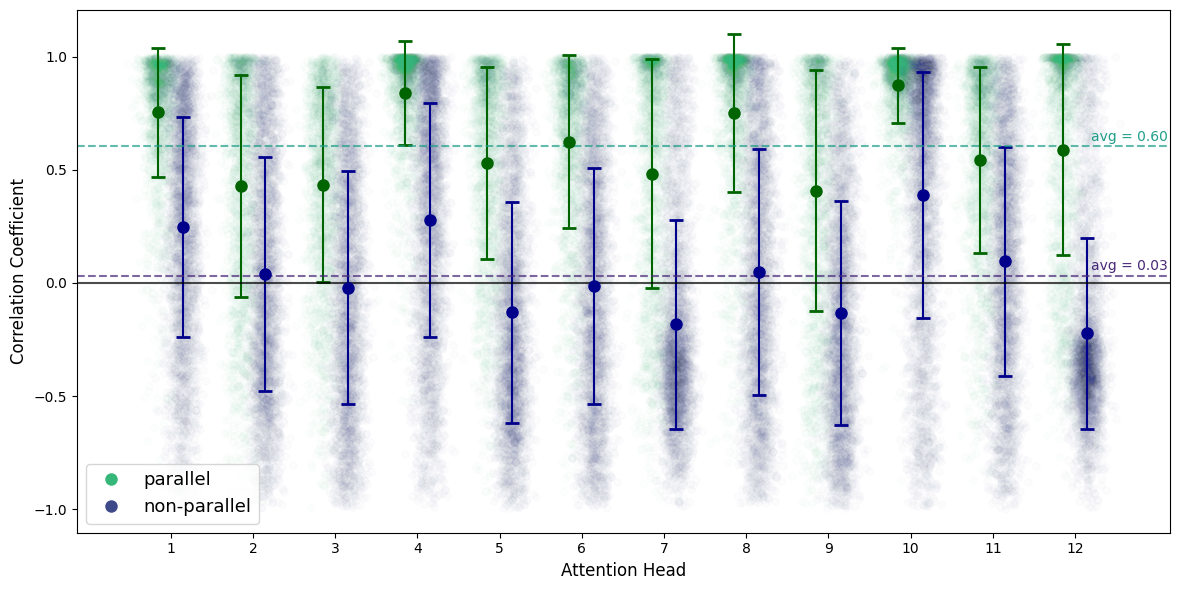

In [9]:
from matplotlib.lines import Line2D
color1 = "#35b779"
color2 = "#3e4989"

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='parallel',
          markerfacecolor=color1, markersize=10, alpha=1),
    Line2D([0], [0], marker='o', color='w', label='non-parallel',
          markerfacecolor=color2, markersize=10, alpha=1),
]
# Prepare for plotting
num_heads = len(means_parallel_p)
head_numbers = np.arange(1, num_heads + 1)
jitter = 0.3  # Spread for the points
alpha = 0.01   # Transparency for points

color1 = "#35b779"  # Parallel color
color2 = "#3e4989"  # Non-parallel color

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual points for parallel couplets
for head in range(num_heads):
    x_values = (head + 1 - jitter/2) + np.random.normal(0, 0.1, size=len(all_parallel_pearson[head]))
    ax.scatter(x_values, all_parallel_pearson[head], color=color1, alpha=alpha, s=30, label='parallel' if head == 0 else "")

# Plot individual points for non-parallel couplets
for head in range(num_heads):
    x_values = (head + 1 + jitter/2) + np.random.normal(0, 0.1, size=len(all_non_parallel_pearson[head]))
    ax.scatter(x_values, all_non_parallel_pearson[head], color=color2, alpha=alpha, s=30, label='non-parallel' if head == 0 else "")

# Plot mean markers and error bars for parallel
ax.errorbar(head_numbers - jitter/2, means_parallel_p, yerr=stds_parallel_p,
            fmt='o', color='darkgreen', markersize=8, capsize=5, capthick=2,
            label='parallel mean ± std')

# Plot mean markers and error bars for non-parallel
ax.errorbar(head_numbers + jitter/2, means_non_parallel_p, yerr=stds_non_parallel_p,
            fmt='o', color='darkblue', markersize=8, capsize=5, capthick=2,
            label='non-parallel mean ± std')

# Add horizontal lines for overall averages
avg_parallel = np.mean(means_parallel_p)
avg_non_parallel = np.mean(means_non_parallel_p)

ax.axhline(y=avg_parallel, color="#1f9e89", linestyle='--', alpha=0.7)
ax.axhline(y=avg_non_parallel, color="#482878", linestyle='--', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.7)

# Add annotations for the average lines
ax.text(num_heads + 0.2, avg_parallel+0.04, f'avg = {avg_parallel:.2f}', color="#1f9e89",
        ha='left', va='center', fontsize=10)
ax.text(num_heads + 0.2, avg_non_parallel+0.04, f'avg = {avg_non_parallel:.2f}', color="#482878",
        ha='left', va='center', fontsize=10)

# Add labels and title
ax.set_xlabel('Attention Head', fontsize=12)
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_xticks(head_numbers)
#ax.set_ylim(1.2)  # Adjust as needed
#ax.legend(loc='upper right')
ax.legend(handles=legend_elements, loc='lower left', fontsize=13)

# Adjust layout
plt.tight_layout()
#plt.savefig("correlation_scatter_with_error_bars.png", dpi=300, bbox_inches="tight")
plt.show()